In [1]:
import numpy as np
import pandas as pd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('../data/example_ndvi_ts.csv')
df.head(5)

,Unnamed: 0,id,longitude,latitude,time,NDVI
0,0,2000_02_18,-95.31462,43.308903,950832000000,2020.0
1,1,2000_03_05,-95.31462,43.308903,952214400000,1929.0
2,2,2000_03_21,-95.31462,43.308903,953596800000,1991.0
3,3,2000_04_06,-95.31462,43.308903,954979200000,2058.0
4,4,2000_04_22,-95.31462,43.308903,956361600000,2372.0


In [3]:
date = []
for i in range(df.shape[0]):
    date.append(pd.Timestamp(df.time[i]*1000000))
    
ts = pd.Series(np.array(df.NDVI)*0.0001,index=date,name='lst')
ts.index.name = 'Date'

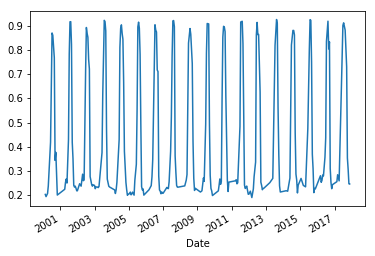

In [4]:
ts.dropna().plot()

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/Users/kmarkert/anaconda3/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
dataset = ts.dropna().values.astype('float32')[:,np.newaxis]

In [7]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [8]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(174, 87)


In [9]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [10]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [11]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [12]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
optimizer = keras.optimizers.RMSprop(lr=0.002)
model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.1571
Epoch 2/100
 - 1s - loss: 0.0883
Epoch 3/100
 - 1s - loss: 0.0670
Epoch 4/100
 - 1s - loss: 0.0528
Epoch 5/100
 - 1s - loss: 0.0469
Epoch 6/100
 - 1s - loss: 0.0444
Epoch 7/100
 - 1s - loss: 0.0464
Epoch 8/100
 - 1s - loss: 0.0459
Epoch 9/100
 - 1s - loss: 0.0461
Epoch 10/100
 - 1s - loss: 0.0460
Epoch 11/100
 - 1s - loss: 0.0458
Epoch 12/100
 - 1s - loss: 0.0454
Epoch 13/100
 - 1s - loss: 0.0462
Epoch 14/100
 - 1s - loss: 0.0459
Epoch 15/100
 - 1s - loss: 0.0458
Epoch 16/100
 - 1s - loss: 0.0463
Epoch 17/100
 - 1s - loss: 0.0460
Epoch 18/100
 - 1s - loss: 0.0457
Epoch 19/100
 - 1s - loss: 0.0458
Epoch 20/100
 - 1s - loss: 0.0454
Epoch 21/100
 - 1s - loss: 0.0456
Epoch 22/100
 - 1s - loss: 0.0454
Epoch 23/100
 - 1s - loss: 0.0455
Epoch 24/100
 - 1s - loss: 0.0453
Epoch 25/100
 - 1s - loss: 0.0461
Epoch 26/100
 - 1s - loss: 0.0456
Epoch 27/100
 - 1s - loss: 0.0460
Epoch 28/100
 - 1s - loss: 0.0457
Epoch 29/100
 - 1s - loss: 0.0452
Epoch 30/100
 - 1s - lo

In [13]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.16 RMSE
Test Score: 0.18 RMSE


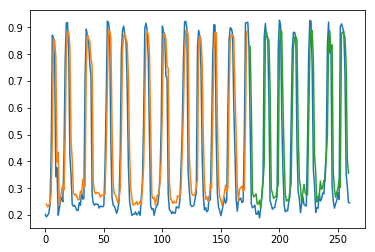

In [14]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()